# Table of Contents

## Stage 1 - Create dataframes of interest and pre-clean the dataframes
* [Step 1.) Compile Yearly Defensive Player Stats into One Dataframe from 2023-2023](#Step1)
        - Load in raw data and compile the 21 files into one dataframe
        - Clean the player names by stripping away symbols denoting all-pro or pro bowl appearances
* [Step 2.) Compile Yearly Defensive Player of the Year Voting from 2003-2023](#Step2)
        - Load in raw data and compile the 21 files into one dataframe
        - Normalize voting data because mechanism of voting changed in 2021
* [Step 3.) Load in NFL team dataset spanning from 2003-2023](#Step3)
        - Load in raw data
        
## Stage 2 - Further clean and merge the dataframes

* [Step 1.) Merge team stats and player stats dataframes](#Step4)
        - Standardize team names between tables because the tables handled team names differently
        - Validate team names are standardized between tables
        - Create concatenated column of team-year
        - Left join tables on team-year concatenated column

* [Step 2.) Merge voting history dataframe with the merged dataframe created above?](#Step5)
        - Create concatenated column of player-team-year
        - Validate player-team-year values are standardized
        - Left join tables on player-team-year concatenated column
        - Verify that all voting history information made it over properly

## Stage 3 - Fully clean and prep the final data set
* [Step 1.) Derive columns containing DPOY voting flags](#Step6)
        - Create and populate 'Received DPOY Vote' column 
        - Create and populate 'Won DPOY' column
        
* [Step 2.) Remove redundant columns from joins and rename columns for clarity](#Step7)

* [Step 3.) Classify players into one or more of the following 3 position groups: Defensive Line, Linebacker, or Defensive Back.](#Step8)
        
* [Step 4.) Remove offensive players that have tackles and defensive stats resulting from turnovers](#Step9)
        
* [Step 5.) Remove players who were traded mid-season, as it's impossible to use seasonal team stats in these cases ](#Step10)

* [Step 6.) Rename additional columns for quality of life](#Step11)

* [Step 7.) Check for NaN values in data columns of interest and fill with 0](#Step12)


## Stage 4 - Create random forest *classifier* data model. Use model to predict probability of a player being in DPOY consideration and receiving at least one vote
* [Part 1.) Create and train random forest binary classication model](#Step13)
        - Define explanatory variables and set dependent variable as Received DPOY Vote
        - Note: using Received DPOY Vote as a proxy because it opens us up to 126 successful outcomes instead of only 21        
* [Part 2.) Visually evaluate model performance](#Step14)
        - Plot ROC Curve
        - Plot feature importances
        
* [Part 3.) Using the model, predict a given player's likelihood of getting a DPOY nod in a given year](#Step15)
* [Part 5.) Using the model, in a given year, provide the single player that is MOST LIKELY to receive a DPOY nod](#Step16)
* [Part 6.) In a given year, provide a dataframe with the top 10 players most likely to get a DPOY nod](#Step17)

## Stage 5 -  Create random forest *regression* data model. Use model to predict the % of DPOY votes a player will receive
* [Part 1.)  Replace NaN 1st place votes with 0](#Step18)
* [Part 2.) Create and train random forest regression model](#Step19)
        - Define explanatory variables and set dependent variable as % of DPOY Votes
        - Note: using % of DPOY Votes as a proxy because it opens us up to 126 data points instead of only 21 
        
* [Part 3.) Visually evaluate model performance](#Step20)
        - Plot True vs. Predicted Values of Test Data
        - Plot feature importances
        
* [Part 4.) For a given year, provide dataframe of top ten players with the highest predicted DPOY Vote %](#Step21)
* [Part 5.) Using the model's predictions, populate a few new columns and normalize the data](#Step22)
        - Create and populate 'Predicted % of vote share' column
        - For each year, normalize the % of vote share so that the sum of all predicted vote % share = 100% for the year
        - Create and populate 'Actual Minus Predicted % of vote share' column
* [Part 6.) Determine how accurately the model correctly predicted the DPOY.](#Step23)
        - Create a list of the years the model incorrectly predicted the DPOY
        - Review the years the model incorrectly predicted the DPOY to investigate what's happening
        
## Stage 6 - Using both the underlying data and the predictions from the regression model, create and answer trivia questions
* [Question 1.) Determine which players had the highest Actual DPOY Vote Share % relative to what was predicted](#Step24)
* [Question 2.)  Determine which players had the highest predicted DPOY vote share % BUT DIDNT WIN](#Step25)
* [Question 3.)  Determine which players had the highest predicted DPOY vote share % BUT DIDNT RECEIVE A DPOY VOTE](#Step26)
* [Question 4.)  Determine which player had the largest negative descrepancy between Actual Vote % and Predicted Vote %](#Step27)
* [Question 5.) Determine which players have the most interceptions since 2003 ](#Step28)
* [Question 6.) Determine which players have the most sacks since 2003 ](#Step29)
* [Question 7.) Determine best and worst defenses since 2003 ](#Step30)
* [Question 8.) Determine what % of DPOY are in each position group ](#Step31)
* [Question 9.)  Determine what % of DPOY Nods go to each position group](#Step32) 


## Stage 7 - Test how well the Random Forest Regression model can predict the DPOY for 5 years of test data that it was not trained on. Run 50 trials with different batches of random test years
* [Step 1.) Using a while loop, run 50 trials with different batches of random years each trial](#Step33)
         - Generate a random batch of 5 years to exclude and set aside as test data
         - After model training, check if the model predicted the DPOY correctly for each of the random test data years
                 - Append trial accuracy to a trial accuracy list
                 
* [Step 2.) Evaluate the average outcome of the combined 50 trials](#Step34)

## Stage 8 - Test how well the  Random Forest Regression model can predict a DPOY for a given year using only the 10 years of data prior to each year 
* [Step 1.)  Cycle through 2013-2023 and test out how well the model can predict a DPOY for a given year using only the 10 years of data prior to each year](#Step35)
* [Step 2.)  Evaluate how well the model performs only using 10 years of prior history](#Step36)
         - Show which years from 2013-2023 successfully had the DPOY correctly predicted
         - Determine proportion of years that successfully had the DPOY correctly predicted

### Important necessary libraries

In [1]:
import os as os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import itertools
from openpyxl import load_workbook
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.4f}'.format
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, plot_roc_curve, plot_confusion_matrix
import random
from sklearn.metrics import r2_score

# Stage 1 - Compile yearly data files into combined dataframes of interest and clean the dataframes

## Load in Defensive Player Stats from 2003-2023 and compile into one dataframe. Clean player names <a class="anchor" id="Step1"></a>

In [2]:
yearly_defensive_player_stats_folder_path = f'{os.getcwd()}\\Defensive Player Stats'

master_df_list = []

cumulative_row_counter = 0

for file_name in os.listdir(yearly_defensive_player_stats_folder_path):
    
    # Assign season value
    year = file_name.split(' ')[0]
    
    # Create dataframe name
    dataframe_name = f'_{file_name.split(".")[0].lower().replace(" ","_")}_df'
    
    # Store dataframe globally with specified name
    globals()[dataframe_name] = pd.read_csv(f'{yearly_defensive_player_stats_folder_path}\\{file_name}',header=1)
    
    # Add a Year Column and assign to year
    globals()[dataframe_name]['Year'] = int(year)
    
    # Append to master_df_list
    master_df_list.append(globals()[dataframe_name]) 
    
    # Cumulative_row_counter
    cumulative_row_counter = cumulative_row_counter + len(globals()[dataframe_name])

master_df_list[2].head(5)

,Rk,Player,Tm,Age,Pos,G,GS,Int,Yds,TD,...,TD.1,Sk,Comb,Solo,Ast,TFL,QBHits,Sfty,-9999,Year
0,1,Jonathan Vilma*,NYJ,23,MLB,16,16,1.0000,1.0000,0,...,0.0000,0.5000,173.0000,128.0000,45.0000,7.0000,NaN,NaN,VilmJo99,2005
1,2,Donnie Edwards,SDG,32,LILB,16,16,2.0000,15.0000,0,...,0.0000,3.0000,154.0000,114.0000,40.0000,4.0000,NaN,NaN,EdwaDo20,2005
2,3,Zach Thomas*,MIA,32,MLB,14,14,1.0000,0.0000,0,...,0.0000,2.0000,162.0000,107.0000,55.0000,13.0000,NaN,NaN,ThomZa01,2005
3,4,London Fletcher,BUF,30,MLB,16,16,1.0000,20.0000,0,...,0.0000,4.0000,158.0000,104.0000,54.0000,6.0000,NaN,1.0000,FletLo20,2005
4,5,Shelton Quarles,TAM,34,MLB,16,16,0.0000,0.0000,0,...,0.0000,1.0000,134.0000,104.0000,30.0000,6.0000,NaN,1.0000,QuarSh20,2005


In [3]:
# Concat all dataframes into one
yearly_defensive_player_stats_df = pd.concat(master_df_list)

# Verify that total record count of master dataframe matches the cumulative record count of the original dataframes
if len(yearly_defensive_player_stats_df)!=cumulative_row_counter:
    raise Exception('Record count of master dataframe does not match cumulative count of component dataframes')
    
# Reset indices
yearly_defensive_player_stats_df.reset_index(drop=True,inplace=True)

yearly_defensive_player_stats_df.head(5)

,Rk,Player,Tm,Age,Pos,G,GS,Int,Yds,TD,...,TD.1,Sk,Comb,Solo,Ast,TFL,QBHits,Sfty,-9999,Year
0,1,Keith Brooking*,ATL,28,LILB,16,16,0.0000,0.0000,0.0000,...,0.0000,0.0000,144.0000,126.0000,18.0000,6.0000,NaN,NaN,BrooKe00,2003
1,2,Donnie Edwards,SDG,30,RLB,16,16,2.0000,27.0000,0.0000,...,0.0000,0.5000,162.0000,124.0000,38.0000,6.0000,NaN,NaN,EdwaDo20,2003
2,3,Ray Lewis*+,BAL,28,RILB,16,16,6.0000,99.0000,1.0000,...,0.0000,1.5000,163.0000,121.0000,42.0000,7.0000,NaN,NaN,LewiRa00,2003
3,4,David Thornton,IND,25,RLB,16,16,2.0000,3.0000,0.0000,...,0.0000,1.0000,145.0000,112.0000,33.0000,6.0000,NaN,NaN,ThorDa20,2003
4,5,Micheal Barrow,NYG,33,MLB,16,16,0.0000,0.0000,0.0000,...,0.0000,2.0000,150.0000,111.0000,39.0000,14.0000,NaN,NaN,BarrMi20,2003


In [4]:
# Clean up player name so that it doesn't have * or + that denotes pro-bowl/all-pro status. Do it twice to address order
yearly_defensive_player_stats_df['Player'] = yearly_defensive_player_stats_df['Player'].str.rstrip('*')
yearly_defensive_player_stats_df['Player'] = yearly_defensive_player_stats_df['Player'].str.rstrip('+')
yearly_defensive_player_stats_df['Player'] = yearly_defensive_player_stats_df['Player'].str.rstrip('*')
yearly_defensive_player_stats_df['Player'] = yearly_defensive_player_stats_df['Player'].str.rstrip('+')

yearly_defensive_player_stats_df

,Rk,Player,Tm,Age,Pos,G,GS,Int,Yds,TD,...,TD.1,Sk,Comb,Solo,Ast,TFL,QBHits,Sfty,-9999,Year
0,1,Keith Brooking,ATL,28,LILB,16,16,0.0000,0.0000,0.0000,...,0.0000,0.0000,144.0000,126.0000,18.0000,6.0000,NaN,NaN,BrooKe00,2003
1,2,Donnie Edwards,SDG,30,RLB,16,16,2.0000,27.0000,0.0000,...,0.0000,0.5000,162.0000,124.0000,38.0000,6.0000,NaN,NaN,EdwaDo20,2003
2,3,Ray Lewis,BAL,28,RILB,16,16,6.0000,99.0000,1.0000,...,0.0000,1.5000,163.0000,121.0000,42.0000,7.0000,NaN,NaN,LewiRa00,2003
3,4,David Thornton,IND,25,RLB,16,16,2.0000,3.0000,0.0000,...,0.0000,1.0000,145.0000,112.0000,33.0000,6.0000,NaN,NaN,ThorDa20,2003
4,5,Micheal Barrow,NYG,33,MLB,16,16,0.0000,0.0000,0.0000,...,0.0000,2.0000,150.0000,111.0000,39.0000,14.0000,NaN,NaN,BarrMi20,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28466,1364,Andrew Wylie,WAS,29,OL,15,15,NaN,NaN,0.0000,...,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,WyliAn00,2023
28467,1365,Bryce Young,CAR,22,QB,16,16,NaN,NaN,0.0000,...,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,YounBr01,2023
28468,1366,Dareke Young,SEA,24,WR,6,0,NaN,NaN,0.0000,...,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,NaN,YounDa02,2023
28469,1367,Kevin Zeitler,BAL,33,G,15,15,NaN,NaN,0.0000,...,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,ZeitKe00,2023


## Load in Defensive Player of the Year Voting History from 2003-2023 and compile into one dataframe. Calculate % of DPOY votes received dynamically because mechanism of voting changed into 2021 <a class="anchor" id="Step2"></a>

In [5]:
yearly_defensive_player_stats_folder_path = f'{os.getcwd()}\\Defensive Player of the Year Voting'

master_df_list = []

cumulative_row_counter = 0

for file_name in os.listdir(yearly_defensive_player_stats_folder_path):
    
    # Assign season value
    year = file_name.split(' ')[0]
    
    # Create dataframe name
    dataframe_name = f'_{file_name.split(".")[0].lower().replace(" ","_")}_df'
    
    # Store dataframe globally with specified name
    globals()[dataframe_name] = pd.read_csv(f'{yearly_defensive_player_stats_folder_path}\\{file_name}',header=1)
    
    # Add a Year Column and assign to year
    globals()[dataframe_name]['Year'] = int(year)
    
    # Append to master_df_list
    master_df_list.append(globals()[dataframe_name]) 
    
    # Cumulative_row_counter
    cumulative_row_counter = cumulative_row_counter + len(globals()[dataframe_name])

master_df_list[2].head(5)

,Rk,Pos,Player,Tm,Votes,Share,G,GS,Solo,Ast,Sk,Int,Yds,TD,-9999,Year
0,1,MLB,Brian Urlacher,Chicago Bears,34.0000,68%,16,16,98,24,6.0000,0,0,0,UrlaBr00,2005
1,2,RDE,Dwight Freeney,Indianapolis Colts,4.0000,8%,16,13,36,6,11.0000,0,0,0,FreeDw00,2005
2,3,SS,Troy Polamalu,Pittsburgh Steelers,3.0000,6%,16,16,74,18,3.0000,2,42,0,PolaTr99,2005
3,4,RDE,Osi Umenyiora,New York Giants,2.0000,4%,16,16,49,22,14.5000,0,0,0,UmenOs99,2005
4,5,SS,Adrian Wilson,Arizona Cardinals,2.0000,4%,16,16,93,16,8.0000,1,36,0,WilsAd99,2005


In [6]:
# Concat all dataframes into one
player_of_the_year_voting_history_df = pd.concat(master_df_list)

# Verify that total record count of master dataframe matches the cumulative record count of the original dataframes
if len(player_of_the_year_voting_history_df)!=cumulative_row_counter:
    raise Exception('Record count of master dataframe does not match cumulative count of component dataframes')
    
# Reset indices
player_of_the_year_voting_history_df.reset_index(drop=True,inplace=True)

player_of_the_year_voting_history_df.head(5)

player_of_the_year_voting_history_df

,Rk,Pos,Player,Tm,Votes,Share,G,GS,Solo,Ast,Sk,Int,Yds,TD,-9999,Year,Vote Pts,1st Place
0,1,RILB,Ray Lewis,Baltimore Ravens,43.0000,86%,16,16,121,42,1.5000,6,99,1,LewiRa00,2003,NaN,NaN
1,2,RDT,Richard Seymour,New England Patriots,2.0000,4%,15,14,34,22,8.0000,0,0,0,SeymRi00,2003,NaN,NaN
2,3,FS,Roy Williams,Dallas Cowboys,2.0000,4%,16,16,57,18,2.0000,2,69,0,WillRo03,2003,NaN,NaN
3,4,SS,Rodney Harrison,New England Patriots,1.0000,2%,16,16,92,33,3.0000,3,0,0,HarrRo01,2003,NaN,NaN
4,5,LDE,Leonard Little,St. Louis Rams,1.0000,2%,12,12,41,6,12.5000,1,28,0,LittLe00,2003,NaN,NaN
5,6,LDE,Trevor Pryce,Denver Broncos,1.0000,2%,16,16,33,11,8.5000,0,0,0,PrycTr00,2003,NaN,NaN
6,1,SS,Ed Reed,Baltimore Ravens,20.0000,41.7%,16,16,64,14,2.0000,9,358,1,ReedEd00,2004,NaN,NaN
7,2,LILB,James Farrior,Pittsburgh Steelers,16.0000,33.3%,16,16,67,28,3.0000,4,113,1,FarrJa99,2004,NaN,NaN
8,3,RDE,Dwight Freeney,Indianapolis Colts,7.0000,14.6%,16,16,33,3,16.0000,0,0,0,FreeDw00,2004,NaN,NaN
9,4,LDE,Julius Peppers,Carolina Panthers,3.0000,6.3%,16,16,53,12,11.0000,2,143,1,PeppJu99,2004,NaN,NaN


In [7]:
#for year in player_of_the_year_voting_history_df['Year'].unique():

# List of years that used votes
traditional_vote_years = list(range(2003,2022))

# List of years that used vote points
vote_point_years = list(range(2022,2024))

for year in traditional_vote_years:

    # Filter down to year
    yearly_vote_sum = player_of_the_year_voting_history_df.loc[player_of_the_year_voting_history_df['Year']==year]['Votes'].sum()

    # Populate a new column with votes
    player_of_the_year_voting_history_df.loc[player_of_the_year_voting_history_df['Year']==year,'% of available votes'] = player_of_the_year_voting_history_df['Votes']/yearly_vote_sum
    
for year in vote_point_years:

    # Filter down to year
    yearly_vote_sum = player_of_the_year_voting_history_df.loc[player_of_the_year_voting_history_df['Year']==year]['Vote Pts'].sum()

    # Populate a new column with votes
    player_of_the_year_voting_history_df.loc[player_of_the_year_voting_history_df['Year']==year,'% of available votes'] = player_of_the_year_voting_history_df['Vote Pts']/yearly_vote_sum

In [8]:
player_of_the_year_voting_history_df

,Rk,Pos,Player,Tm,Votes,Share,G,GS,Solo,Ast,Sk,Int,Yds,TD,-9999,Year,Vote Pts,1st Place,% of available votes
0,1,RILB,Ray Lewis,Baltimore Ravens,43.0000,86%,16,16,121,42,1.5000,6,99,1,LewiRa00,2003,NaN,NaN,0.8600
1,2,RDT,Richard Seymour,New England Patriots,2.0000,4%,15,14,34,22,8.0000,0,0,0,SeymRi00,2003,NaN,NaN,0.0400
2,3,FS,Roy Williams,Dallas Cowboys,2.0000,4%,16,16,57,18,2.0000,2,69,0,WillRo03,2003,NaN,NaN,0.0400
3,4,SS,Rodney Harrison,New England Patriots,1.0000,2%,16,16,92,33,3.0000,3,0,0,HarrRo01,2003,NaN,NaN,0.0200
4,5,LDE,Leonard Little,St. Louis Rams,1.0000,2%,12,12,41,6,12.5000,1,28,0,LittLe00,2003,NaN,NaN,0.0200
5,6,LDE,Trevor Pryce,Denver Broncos,1.0000,2%,16,16,33,11,8.5000,0,0,0,PrycTr00,2003,NaN,NaN,0.0200
6,1,SS,Ed Reed,Baltimore Ravens,20.0000,41.7%,16,16,64,14,2.0000,9,358,1,ReedEd00,2004,NaN,NaN,0.4167
7,2,LILB,James Farrior,Pittsburgh Steelers,16.0000,33.3%,16,16,67,28,3.0000,4,113,1,FarrJa99,2004,NaN,NaN,0.3333
8,3,RDE,Dwight Freeney,Indianapolis Colts,7.0000,14.6%,16,16,33,3,16.0000,0,0,0,FreeDw00,2004,NaN,NaN,0.1458
9,4,LDE,Julius Peppers,Carolina Panthers,3.0000,6.3%,16,16,53,12,11.0000,2,143,1,PeppJu99,2004,NaN,NaN,0.0625


## Load in NFL Team Stats Dataset from 2003-2023  <a class="anchor" id="Step3"></a>

In [9]:
# Read in raw data 
yearly_team_stats = pd.read_excel('NFL Team Dataset Original.xlsx')

# Filter down only to stats of interest
yearly_team_stats = yearly_team_stats[['year','team','win_loss_perc','points_opp']]

yearly_team_stats.rename(columns={'year':'Year','team':'Team','win_loss_perc':'Win Loss Percentage','points_opp':'Points allowed'},inplace=True)

yearly_team_stats


,Year,Team,Win Loss Percentage,Points allowed
0,2003,New England Patriots,0.8750,238
1,2003,Miami Dolphins,0.6250,261
2,2003,Buffalo Bills,0.3750,279
3,2003,New York Jets,0.3750,299
4,2003,Baltimore Ravens,0.6250,281
...,...,...,...,...
667,2023,Carolina Panthers,0.1180,416
668,2023,San Francisco 49ers,0.7060,298
669,2023,Los Angeles Rams,0.5880,377
670,2023,Seattle Seahawks,0.5290,402


# Stage 2 - Merge the three dataframes into one

### Merge player stats with team stats so you can see how their team performed in addition to the player in a given year.

### Merge on concat of team name + year. 

### Standardize team names across tables to do so <a class="anchor" id="Step4"></a>

In [10]:
# Unfortunately, team names were in different formats between dataframes. 
# Let's standardize before we create a team name + year concat to join tables on

# Create and export list of team names to compare and create matches
team_name_df_to_review = pd.DataFrame()
team_name_df_to_review['Team name from yearly team stats'] = pd.Series(yearly_team_stats['Team'].unique())
team_name_df_to_review['Team name from yearly defensive player stats'] = pd.Series(yearly_defensive_player_stats_df['Tm'].unique())
team_name_df_to_review.to_excel('Team Name Matching Dictionary Exercise.xlsx')

# After manually reviewing the list to create matches, load back in and create dictionary.
# Then replace team names in yearly defensive player stats df to standardize across tables
reviewed_team_name_dict_df = pd.read_excel('Team Name Matching Dictionary Exercise Reviewed.xlsx')
name_replacement_dict = dict(zip(reviewed_team_name_dict_df['Team name from yearly defensive player stats'],reviewed_team_name_dict_df['Team Name to Change To']))
yearly_defensive_player_stats_df['Tm'] = yearly_defensive_player_stats_df['Tm'].replace(name_replacement_dict)

# Do one additional manual replacement of one forgotten team name
yearly_defensive_player_stats_df['Tm'] = yearly_defensive_player_stats_df['Tm'].replace({'LVR':'Las Vegas Raiders','2TM':'Multiple Teams','3TM':'Multiple Teams','4TM':'Multiple Teams'})

# Do a dictionary replacement for yearly team stats for WAS, as their team changed name 3 times.  
yearly_team_stats['Team'] = yearly_team_stats['Team'].replace({'Washington Redskins':'Washington Commanders','Washington Football Team':'Washington Commanders'})

# Create team - year concat columns to merge team stats with player stats 
yearly_team_stats['team_year_concat'] = yearly_team_stats['Team'].astype(str) + '-' + yearly_team_stats['Year'].astype(str)
yearly_defensive_player_stats_df['team_year_concat'] = yearly_defensive_player_stats_df['Tm'].astype(str) + '-' + yearly_defensive_player_stats_df['Year'].astype(str)

# Merge team stats and player stats tables 
merged_df = yearly_defensive_player_stats_df.merge(yearly_team_stats,how='left',on='team_year_concat')

merged_df

,Rk,Player,Tm,Age,Pos,G,GS,Int,Yds,TD,...,TFL,QBHits,Sfty,-9999,Year_x,team_year_concat,Year_y,Team,Win Loss Percentage,Points allowed
0,1,Keith Brooking,Atlanta Falcons,28,LILB,16,16,0.0000,0.0000,0.0000,...,6.0000,NaN,NaN,BrooKe00,2003,Atlanta Falcons-2003,2003.0000,Atlanta Falcons,0.3130,422.0000
1,2,Donnie Edwards,San Diego Chargers,30,RLB,16,16,2.0000,27.0000,0.0000,...,6.0000,NaN,NaN,EdwaDo20,2003,San Diego Chargers-2003,2003.0000,San Diego Chargers,0.2500,441.0000
2,3,Ray Lewis,Baltimore Ravens,28,RILB,16,16,6.0000,99.0000,1.0000,...,7.0000,NaN,NaN,LewiRa00,2003,Baltimore Ravens-2003,2003.0000,Baltimore Ravens,0.6250,281.0000
3,4,David Thornton,Indianapolis Colts,25,RLB,16,16,2.0000,3.0000,0.0000,...,6.0000,NaN,NaN,ThorDa20,2003,Indianapolis Colts-2003,2003.0000,Indianapolis Colts,0.7500,336.0000
4,5,Micheal Barrow,New York Giants,33,MLB,16,16,0.0000,0.0000,0.0000,...,14.0000,NaN,NaN,BarrMi20,2003,New York Giants-2003,2003.0000,New York Giants,0.2500,387.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28466,1364,Andrew Wylie,Washington Commanders,29,OL,15,15,NaN,NaN,0.0000,...,NaN,NaN,NaN,WyliAn00,2023,Washington Commanders-2023,2023.0000,Washington Commanders,0.2350,518.0000
28467,1365,Bryce Young,Carolina Panthers,22,QB,16,16,NaN,NaN,0.0000,...,NaN,NaN,NaN,YounBr01,2023,Carolina Panthers-2023,2023.0000,Carolina Panthers,0.1180,416.0000
28468,1366,Dareke Young,Seattle Seahawks,24,WR,6,0,NaN,NaN,0.0000,...,0.0000,0.0000,NaN,YounDa02,2023,Seattle Seahawks-2023,2023.0000,Seattle Seahawks,0.5290,402.0000
28469,1367,Kevin Zeitler,Baltimore Ravens,33,G,15,15,NaN,NaN,0.0000,...,NaN,NaN,NaN,ZeitKe00,2023,Baltimore Ravens-2023,2023.0000,Baltimore Ravens,0.7650,280.0000


In [11]:
for team in yearly_team_stats['Team'].unique():
     
    if team not in yearly_defensive_player_stats_df['Tm'].unique():
        print(team)

In [12]:
for team in yearly_defensive_player_stats_df['Tm'].unique():
     
    if team not in yearly_team_stats['Team'].unique():
        print(team)

Multiple Teams


## Merge voting history dataframe with the previously joined team + player stats dataframe <a class="anchor" id="Step5"></a>

In [13]:
player_of_the_year_voting_history_df = player_of_the_year_voting_history_df[['Rk','Pos','Player','Tm','% of available votes','Year']]

# Do a dictionary replacement for yearly team stats for WAS, as their team changed name 3 times.  
player_of_the_year_voting_history_df['Tm'] = player_of_the_year_voting_history_df['Tm'].replace({'Washington Redskins':'Washington Commanders','Washington Football Team':'Washington Commanders'})

# Create concat in merged dataframe of player -> team -> year for purposes of join 
merged_df.loc[:,('player_team_year_concat')] = merged_df['Player'].astype(str) + '-' + merged_df['Tm'].astype(str) + '-' + merged_df['Year_x'].astype(str)

# Create concat in player voting dataframe of player -> team -> year for purposes of join
player_of_the_year_voting_history_df.loc[:,('player_team_year_concat')] = player_of_the_year_voting_history_df['Player'].astype(str) + '-' + player_of_the_year_voting_history_df['Tm'].astype(str) + '-' + player_of_the_year_voting_history_df['Year'].astype(str)

player_of_the_year_voting_history_df.head(5)

C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2147298997.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_of_the_year_voting_history_df['Tm'] = player_of_the_year_voting_history_df['Tm'].replace({'Washington Redskins':'Washington Commanders','Washington Football Team':'Washington Commanders'})
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2147298997.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_of_the_year_voting_history_df.loc[:,('player_team_year_concat')] = player_of_the_y

,Rk,Pos,Player,Tm,% of available votes,Year,player_team_year_concat
0,1,RILB,Ray Lewis,Baltimore Ravens,0.8600,2003,Ray Lewis-Baltimore Ravens-2003
1,2,RDT,Richard Seymour,New England Patriots,0.0400,2003,Richard Seymour-New England Patriots-2003
2,3,FS,Roy Williams,Dallas Cowboys,0.0400,2003,Roy Williams-Dallas Cowboys-2003
3,4,SS,Rodney Harrison,New England Patriots,0.0200,2003,Rodney Harrison-New England Patriots-2003
4,5,LDE,Leonard Little,St. Louis Rams,0.0200,2003,Leonard Little-St. Louis Rams-2003


In [14]:
# Check to make sure team names will join

for team in player_of_the_year_voting_history_df['Tm'].unique():
     
    if team not in yearly_team_stats['Team'].unique():
        print(team)

In [15]:
# Merge together
final_merged_df = merged_df.merge(player_of_the_year_voting_history_df,how='left',on='player_team_year_concat')
final_merged_df

,Rk_x,Player_x,Tm_x,Age,Pos_x,G,GS,Int,Yds,TD,...,Team,Win Loss Percentage,Points allowed,player_team_year_concat,Rk_y,Pos_y,Player_y,Tm_y,% of available votes,Year
0,1,Keith Brooking,Atlanta Falcons,28,LILB,16,16,0.0000,0.0000,0.0000,...,Atlanta Falcons,0.3130,422.0000,Keith Brooking-Atlanta Falcons-2003,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Donnie Edwards,San Diego Chargers,30,RLB,16,16,2.0000,27.0000,0.0000,...,San Diego Chargers,0.2500,441.0000,Donnie Edwards-San Diego Chargers-2003,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Ray Lewis,Baltimore Ravens,28,RILB,16,16,6.0000,99.0000,1.0000,...,Baltimore Ravens,0.6250,281.0000,Ray Lewis-Baltimore Ravens-2003,1.0000,RILB,Ray Lewis,Baltimore Ravens,0.8600,2003.0000
3,4,David Thornton,Indianapolis Colts,25,RLB,16,16,2.0000,3.0000,0.0000,...,Indianapolis Colts,0.7500,336.0000,David Thornton-Indianapolis Colts-2003,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Micheal Barrow,New York Giants,33,MLB,16,16,0.0000,0.0000,0.0000,...,New York Giants,0.2500,387.0000,Micheal Barrow-New York Giants-2003,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28466,1364,Andrew Wylie,Washington Commanders,29,OL,15,15,NaN,NaN,0.0000,...,Washington Commanders,0.2350,518.0000,Andrew Wylie-Washington Commanders-2023,NaN,NaN,NaN,NaN,NaN,NaN
28467,1365,Bryce Young,Carolina Panthers,22,QB,16,16,NaN,NaN,0.0000,...,Carolina Panthers,0.1180,416.0000,Bryce Young-Carolina Panthers-2023,NaN,NaN,NaN,NaN,NaN,NaN
28468,1366,Dareke Young,Seattle Seahawks,24,WR,6,0,NaN,NaN,0.0000,...,Seattle Seahawks,0.5290,402.0000,Dareke Young-Seattle Seahawks-2023,NaN,NaN,NaN,NaN,NaN,NaN
28469,1367,Kevin Zeitler,Baltimore Ravens,33,G,15,15,NaN,NaN,0.0000,...,Baltimore Ravens,0.7650,280.0000,Kevin Zeitler-Baltimore Ravens-2023,NaN,NaN,NaN,NaN,NaN,NaN


## Create and populate a "considered for defensive player of the year flag" and "won defensive player of the year flag" using data from 

In [16]:
# Verify that all player-years were successfully merged by checking record counts
print(len(player_of_the_year_voting_history_df))
print(len(final_merged_df.loc[final_merged_df['% of available votes'].notnull()]))

125
125


# Stage 3 - Fully clean up and prep the final data set 

### Create and populate 'Received DPOY Votes' and 'Won DPOY' columns <a class="anchor" id="Step6"></a>

In [17]:
# Populate a newly created column as binary 0/1 based on whether or not they received votes
final_merged_df['Received DPOY Votes'] = np.nan
final_merged_df.loc[final_merged_df['% of available votes'].notnull(),'Received DPOY Votes'] = 1
final_merged_df.loc[final_merged_df['% of available votes'].isnull(),'Received DPOY Votes'] = 0

In [18]:
# Populate a newly created column as binary 0/1 based on whether or not they received votes
final_merged_df['Won DPOY'] = np.nan
final_merged_df.loc[final_merged_df['Rk_y']==1,'Won DPOY'] = 1
final_merged_df.loc[final_merged_df['Rk_y']!=1,'Won DPOY'] = 0

### 1.) Remove redundant columns and rename columns for clarity <a class="anchor" id="Step7"></a>

In [19]:
final_merged_df.columns

Index(['Rk_x', 'Player_x', 'Tm_x', 'Age', 'Pos_x', 'G', 'GS', 'Int', 'Yds',
       'TD', 'Lng', 'PD', 'FF', 'Fmb', 'FR', 'Yds.1', 'TD.1', 'Sk', 'Comb',
       'Solo', 'Ast', 'TFL', 'QBHits', 'Sfty', '-9999', 'Year_x',
       'team_year_concat', 'Year_y', 'Team', 'Win Loss Percentage',
       'Points allowed', 'player_team_year_concat', 'Rk_y', 'Pos_y',
       'Player_y', 'Tm_y', '% of available votes', 'Year',
       'Received DPOY Votes', 'Won DPOY'],
      dtype='object')

In [20]:
final_merged_df = final_merged_df[['Player_x',
                                   'Year_x',
                                   'Tm_x',
                                   'Age',
                                   'Pos_x',
                                   'G',
                                   'GS',
                                   'Int',
                                   'Yds',
                                   'TD',
                                   'Lng',
                                   'PD',
                                   'FF',
                                   'Fmb',
                                   'FR',
                                   'Yds.1',
                                   'TD.1',
                                   'Sk',
                                   'Comb',
                                   'Solo',
                                   'Ast',
                                   'TFL',
                                   'QBHits',
                                   'Sfty',
                                   'Win Loss Percentage',
                                   'Points allowed',
                                   'Received DPOY Votes',
                                   '% of available votes',
                                   'Won DPOY']]

final_merged_df = final_merged_df.rename(columns={'Player_x':'Player','Tm_x':'Team','Pos_x':'Position','Year_x':'Year','Share':'% 1st Place Vote Share'})
final_merged_df

,Player,Year,Team,Age,Position,G,GS,Int,Yds,TD,...,Solo,Ast,TFL,QBHits,Sfty,Win Loss Percentage,Points allowed,Received DPOY Votes,% of available votes,Won DPOY
0,Keith Brooking,2003,Atlanta Falcons,28,LILB,16,16,0.0000,0.0000,0.0000,...,126.0000,18.0000,6.0000,NaN,NaN,0.3130,422.0000,0.0000,NaN,0.0000
1,Donnie Edwards,2003,San Diego Chargers,30,RLB,16,16,2.0000,27.0000,0.0000,...,124.0000,38.0000,6.0000,NaN,NaN,0.2500,441.0000,0.0000,NaN,0.0000
2,Ray Lewis,2003,Baltimore Ravens,28,RILB,16,16,6.0000,99.0000,1.0000,...,121.0000,42.0000,7.0000,NaN,NaN,0.6250,281.0000,1.0000,0.8600,1.0000
3,David Thornton,2003,Indianapolis Colts,25,RLB,16,16,2.0000,3.0000,0.0000,...,112.0000,33.0000,6.0000,NaN,NaN,0.7500,336.0000,0.0000,NaN,0.0000
4,Micheal Barrow,2003,New York Giants,33,MLB,16,16,0.0000,0.0000,0.0000,...,111.0000,39.0000,14.0000,NaN,NaN,0.2500,387.0000,0.0000,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28466,Andrew Wylie,2023,Washington Commanders,29,OL,15,15,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,0.2350,518.0000,0.0000,NaN,0.0000
28467,Bryce Young,2023,Carolina Panthers,22,QB,16,16,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,0.1180,416.0000,0.0000,NaN,0.0000
28468,Dareke Young,2023,Seattle Seahawks,24,WR,6,0,NaN,NaN,0.0000,...,0.0000,1.0000,0.0000,0.0000,NaN,0.5290,402.0000,0.0000,NaN,0.0000
28469,Kevin Zeitler,2023,Baltimore Ravens,33,G,15,15,NaN,NaN,0.0000,...,NaN,NaN,NaN,NaN,NaN,0.7650,280.0000,0.0000,NaN,0.0000


### 2.) Classify players into one or more of the following 3 position groups: Defensive Line, Linebacker, or Defensive Back. <a class="anchor" id="Step8"></a>

In [21]:
# Parse position data to create a collective list of all player positions found in defensive data
list_of_all_positions = []

for position in final_merged_df['Position'].unique():
    
    position = str(position)
    
    if len(position.split('/'))==1:
        
        list_of_all_positions.append(position)
    
    if len(position.split('/'))==2:
        
        position_1 = position.split('/')[0]
        
        position_2 = position.split('/')[1]
        
        list_of_all_positions.append(position_1)
        
        list_of_all_positions.append(position_2)
        
    if len(position.split('/'))==3: 
        
        position_1 = position.split('/')[0]
        
        position_2 = position.split('/')[1]
        
        position_3 = position.split('/')[2]
        
        list_of_all_positions.append(position_1)
        
        list_of_all_positions.append(position_2)
        
        list_of_all_positions.append(position_3)
        
# Review all positions and create list of defensive positions so that we can filter out offensive players with defensive data
set(list_of_all_positions)
list_of_valid_defensive_positions = ['CB','DB','DE','DL','DT','FS','ILB','LB','LCB','LDE','LDT','LILB','LLB','LOLB','MLB','NT','OLB','RCB','RDE','RDT','RILB','RLB','ROLB','S','SS']


# Place defensive positions found into one of the groups: Defensive Line, Linebackers, or Defensive Backs
dict_of_defensive_positions = {'CB':'DB',
                             'DB':'DB',
                             'DE':'DL',
                             'DL':'DL',
                             'DT':'DL',
                             'FS':'DB',
                             'ILB':'LB',
                             'LB':'LB',
                             'LCB':'DB',
                             'LDE':'DL',
                             'LDT':'DL',
                             'LILB':'LB',
                             'LLB':'LB',
                             'LOLB':'LB',
                             'MLB':'LB',
                             'NT':'DL',
                             'OLB':'LB',
                             'RCB':'DB',
                             'RDE':'DL',
                             'RDT':'DL',
                             'RILB':'LB',
                             'RLB':'LB',
                             'ROLB':'LB',
                             'S':'DB',
                             'SS':'DB'}

In [22]:
def linebacker_placer(original_positions,position_group_you_want_to_make_sure_is_contained='LB'):
    
    original_positions = str(original_positions)
    
    list_of_transformed_positions = []
    
    for position in original_positions.split('/'):
        
        if position in list_of_valid_defensive_positions:
            
            position = dict_of_defensive_positions[position]

            list_of_transformed_positions.append(position)

    if position_group_you_want_to_make_sure_is_contained in list_of_transformed_positions:
        
        return 1
    
    else:
        return 0
    
def defensive_line_placer(original_positions,position_group_you_want_to_make_sure_is_contained='DL'):
    
    original_positions = str(original_positions)
    
    list_of_transformed_positions = []
    
    for position in original_positions.split('/'):
        
        if position in list_of_valid_defensive_positions:
            
            position = dict_of_defensive_positions[position]

            list_of_transformed_positions.append(position)

    if position_group_you_want_to_make_sure_is_contained in list_of_transformed_positions:
        
        return 1
    
    else:
        return 0
    
def defensive_back_placer(original_positions,position_group_you_want_to_make_sure_is_contained='DB'):
    
    original_positions = str(original_positions)
    
    list_of_transformed_positions = []
    
    for position in original_positions.split('/'):
        
        if position in list_of_valid_defensive_positions:
            
            position = dict_of_defensive_positions[position]

            list_of_transformed_positions.append(position)

    if position_group_you_want_to_make_sure_is_contained in list_of_transformed_positions:
        
        return 1
    
    else:
        return 0

In [23]:
final_merged_df['Played Defensive Line'] = np.nan
final_merged_df['Played Linebacker'] = np.nan
final_merged_df['Played Defensive Back'] = np.nan

final_merged_df['Played Defensive Line'] = final_merged_df['Position'].apply(defensive_line_placer)
final_merged_df['Played Linebacker'] = final_merged_df['Position'].apply(linebacker_placer)
final_merged_df['Played Defensive Back'] = final_merged_df['Position'].apply(defensive_back_placer)

### 3.) Filter out players that have defensive stats, but aren't on the defense <a class="anchor" id="Step9"></a>

In [24]:
final_merged_df = final_merged_df.loc[(final_merged_df['Played Linebacker']!=0)|(final_merged_df['Played Defensive Line']!=0)|(final_merged_df['Played Defensive Back']!=0)]

### 4.) Remove players who were traded mid-season, as it's impossible to use seasonal team stats in these cases <a class="anchor" id="Step10"></a>

In [25]:
# Remove players who were traded mid season, as our dataset doesn't hold team-related data for them 
final_merged_df = final_merged_df.loc[~(final_merged_df['Team']=='Multiple Teams')]

### 5.) Rename columns for quality of life <a class="anchor" id="Step11"></a>

In [26]:
final_merged_df.columns

Index(['Player', 'Year', 'Team', 'Age', 'Position', 'G', 'GS', 'Int', 'Yds',
       'TD', 'Lng', 'PD', 'FF', 'Fmb', 'FR', 'Yds.1', 'TD.1', 'Sk', 'Comb',
       'Solo', 'Ast', 'TFL', 'QBHits', 'Sfty', 'Win Loss Percentage',
       'Points allowed', 'Received DPOY Votes', '% of available votes',
       'Won DPOY', 'Played Defensive Line', 'Played Linebacker',
       'Played Defensive Back'],
      dtype='object')

In [27]:
column_rename_dict = {'GS':'Games Started',
                     'Int':'Interceptions',
                     'Yds':'Yards of Interception Return',
                     'TD':'Interceptions returned for TD',
                     'Lng':'Longest interception return',
                     'PD':'Passes Defended',
                     'FF':'Forced Fumbles',
                     'FR':'Fumbles Recovered',
                    'Yds':'Yards fumbles were returned',
                    'TD.1':'Fumbles returned for TD',
                      'Sk':'Sacks',
                      'Solo':'Solo tackle',
                      'Ast':'Assists on tackles',
                      'TFL':'Tackles for loss',
                      'QBHits':'QB Hits',
                      'Sfty':'Safeties scored'
                     }

final_merged_df = final_merged_df.rename(columns=column_rename_dict)

### Check for NaN values, as they will be a problem. Populate with 0. <a class="anchor" id="Step12"></a>

In [28]:
features = ['Games Started',
             'Interceptions',
             'Yards fumbles were returned',
             'Interceptions returned for TD',
             'Longest interception return',
             'Passes Defended',
             'Forced Fumbles',
             'Fumbles Recovered',
             'Fumbles returned for TD',
             'Sacks',
             'Solo tackle',
             'Assists on tackles',
             'Tackles for loss',
             'QB Hits',
             'Safeties scored',
            'Win Loss Percentage',
            'Points allowed',
            'Played Defensive Line',
            'Played Linebacker',
            'Played Defensive Back']

for feature in features:
    
    print(f'{feature} contains {len(final_merged_df.loc[final_merged_df[feature].isnull()])} null values')
    
    # Replace null values with 0 
    final_merged_df.loc[final_merged_df[feature].isnull(),feature] = 0
    
    print(f'{feature} contains {len(final_merged_df.loc[final_merged_df[feature].isnull()])} null values')

Games Started contains 0 null values
Games Started contains 0 null values
Interceptions contains 7305 null values
Interceptions contains 0 null values
Yards fumbles were returned contains 7305 null values
Yards fumbles were returned contains 0 null values
Interceptions returned for TD contains 12 null values
Interceptions returned for TD contains 0 null values
Longest interception return contains 7305 null values
Longest interception return contains 0 null values
Passes Defended contains 7303 null values
Passes Defended contains 0 null values
Forced Fumbles contains 9745 null values
Forced Fumbles contains 0 null values
Fumbles Recovered contains 10304 null values
Fumbles Recovered contains 0 null values
Fumbles returned for TD contains 4990 null values
Fumbles returned for TD contains 0 null values
Sacks contains 0 null values
Sacks contains 0 null values
Solo tackle contains 35 null values
Solo tackle contains 0 null values
Assists on tackles contains 35 null values
Assists on tackle

In [29]:
final_merged_df.to_excel('Merged NFL Data.xlsx')

# Stage 4 - Random Forest Binary Classification Model:
# Predicting probability of receiving a DPOY nod

### Create and train random forest binary classification data model <a class="anchor" id="Step13"></a>

In [59]:
# Assuming 'DPOY_winner' is your target variable indicating whether a player won the DPOY award
data = final_merged_df

# Assuming 'features' is a list of features you want to use for prediction
features = ['Games Started',
             'Interceptions',
             'Yards fumbles were returned',
             'Interceptions returned for TD',
             'Longest interception return',
             'Passes Defended',
             'Forced Fumbles',
             'Fumbles Recovered',
             'Fumbles returned for TD',
             'Sacks',
             'Solo tackle',
             'Assists on tackles',
             'Tackles for loss',
             'QB Hits',
             'Safeties scored',
            'Win Loss Percentage',
            'Points allowed',
            'Played Defensive Line',
            'Played Linebacker',
            'Played Defensive Back']  # Add your features here

target = 'Received DPOY Votes' # or try using Received DPOY votes

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Initialize the random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict probabilities on the test set
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model (you can use different evaluation metrics based on your requirements)
accuracy = accuracy_score(y_test, y_pred_proba.round())
auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy}')
print(f'AUC: {auc}')

Accuracy: 0.9948842218632202
AUC: 0.985986901535682


### Visually evaluate model performance <a class="anchor" id="Step14"></a>

C:\Users\Carey\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


<Figure size 800x600 with 0 Axes>

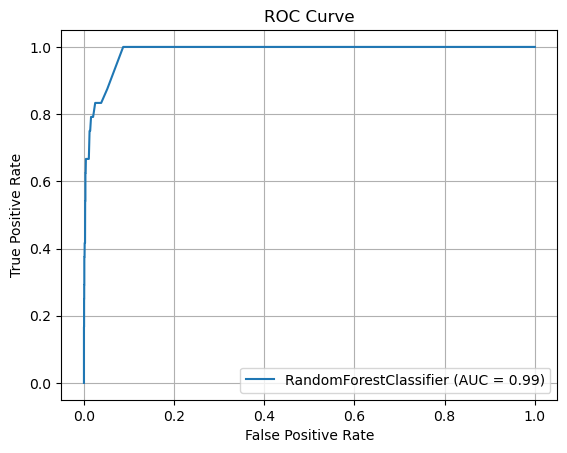

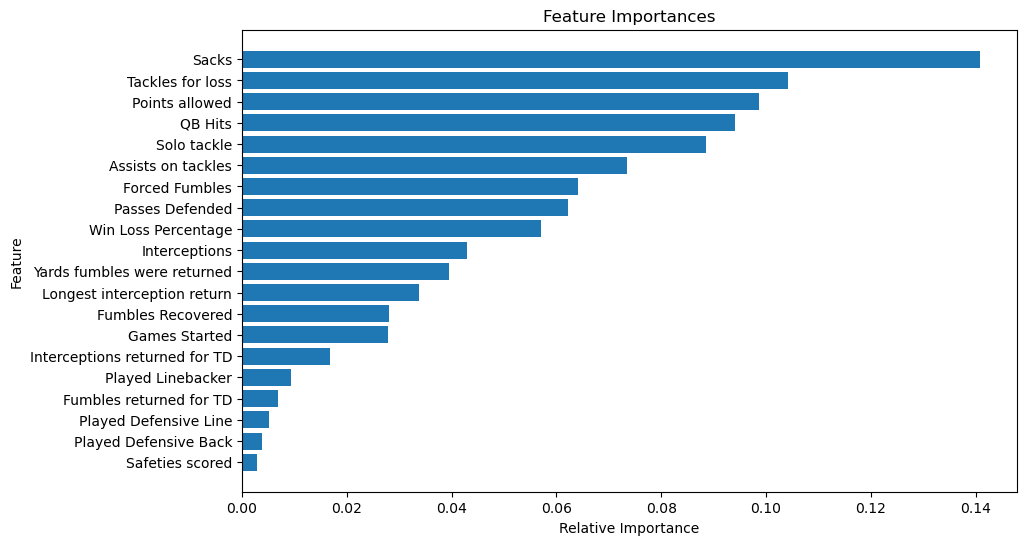

In [60]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plot_roc_curve(rf_classifier, X_test, y_test)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances = rf_classifier.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh([features[i] for i in sorted_idx], feature_importances[sorted_idx])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

### Predict a given player's likelihood of getting a DPOY nod in a given year <a class="anchor" id="Step15"></a>

In [67]:
# Define arguments
player_name = 'T.J. Watt' ## Use str type
season = 2023 ## Use INT type

# Define feature list (predictive columns)
features = ['Games Started',
             'Interceptions',
             'Yards fumbles were returned',
             'Interceptions returned for TD',
             'Longest interception return',
             'Passes Defended',
             'Forced Fumbles',
             'Fumbles Recovered',
             'Fumbles returned for TD',
             'Sacks',
             'Solo tackle',
             'Assists on tackles',
             'Tackles for loss',
             'QB Hits',
             'Safeties scored',
            'Win Loss Percentage',
            'Points allowed',
            'Played Defensive Line',
            'Played Linebacker',
            'Played Defensive Back']

# Create a dataframe containing just the index for the player/season combination of interest
test_sample_df = final_merged_df.loc[(final_merged_df['Player']==player_name)&(final_merged_df['Year']==season)].reset_index(drop=True)

# Predict probabilities for the test sample
predicted_probabilities = rf_classifier.predict_proba(test_sample_df[features])

print("Predicted probabilities:")
print(f"Probability of not getting DPOY nod: {predicted_probabilities[0][0]}")
print(f"Probability of getting DPOY nod: {predicted_probabilities[0][1]}")

Predicted probabilities:
Probability of not getting DPOY nod: 0.11
Probability of getting DPOY nod: 0.89


### Using the model, in a given year, provide the player that is most likely to receive a DPOY nod <a class="anchor" id="Step16"></a>

In [72]:
def predict_mvp(df_players, model, features):
    """
    Predicts the most likely player to receive DPOY nod from a DataFrame of players for a given year.
    
    Parameters:
    - df_players: DataFrame containing player information for a given year.
    - model: Trained classification model (Random Forest Classifier).
    - features: List of features used for prediction.
    
    Returns:
    - player_most_likely_mvp: Name of the player most likely to win MVP (Defensive Player of the Year).
    - probability_mvp: Predicted probability of the player winning MVP.
    """
    # Predict probabilities for all players
    predicted_probabilities = model.predict_proba(df_players[features])
    
    # Find the index of the player with the highest probability of winning MVP
    idx_most_likely_mvp = predicted_probabilities[:, 1].argmax()
    
    # Get the name of the player most likely to win MVP and their corresponding probability
    player_most_likely_mvp = df_players.iloc[idx_most_likely_mvp]['Player']
    probability_mvp = predicted_probabilities[idx_most_likely_mvp, 1]
    
    return player_most_likely_mvp, probability_mvp

# Define year of interest
year = 2023

# Create dataframe
df_players_2023 = final_merged_df.loc[final_merged_df['Year']==year]

# Predict the most likely MVP for the given year
mvp_player, mvp_probability = predict_mvp(df_players_2023, rf_classifier, features)

print(f"The player most likely to get a DPOY nod in 2023 is: {mvp_player}")
print(f"Probability of winning MVP: {mvp_probability}")

The player most likely to get a DPOY nod in 2023 is: T.J. Watt
Probability of winning MVP: 0.89


### In a given year, provide a dataframe with the top 10 players most likely to get a DPOY nod <a class="anchor" id="Step17"></a>

In [71]:
def predict_top_mvp(df_players, model, features, top_n=5):
    """
    Predicts the top N players most likely to win MVP (Defensive Player of the Year) from a DataFrame of players for a given year.
    
    Parameters:
    - df_players: DataFrame containing player information for a given year.
    - model: Trained classification model (Random Forest Classifier).
    - features: List of features used for prediction.
    - top_n: Number of top players to return (default is 5).
    
    Returns:
    - df_top_mvp: DataFrame containing the top N players most likely to win MVP, sorted by likelihood.
    """
    # Predict probabilities for all players
    predicted_probabilities = model.predict_proba(df_players[features])
    
    # Create DataFrame to store player names and probabilities
    df_players_proba = pd.DataFrame({
        'Player': df_players['Player'],
        'Probability of getting a DPOY nod': predicted_probabilities[:, 1],
        'Received DPOY Votes':df_players['Received DPOY Votes'],
        '1st Place Vote % Received':df_players['% of available votes'],
        'Won DPOY':df_players['Won DPOY'],
    })
    
    # Sort DataFrame by probability in descending order and select top N players
    df_top_mvp = df_players_proba.sort_values(by='Probability of getting a DPOY nod', ascending=False).head(top_n)
    
    return df_top_mvp

# Define year of interest
year = 2023


df_players_year = final_merged_df.loc[final_merged_df['Year']==year]

# Predict the top 5 players most likely to win MVP for the given year
df_top_mvp_2023 = predict_top_mvp(df_players_year, rf_classifier, features, top_n=10)
df_top_mvp_2023.loc[df_top_mvp_2023['Received DPOY Votes']==1,'Received DPOY Votes'] = 'X'
df_top_mvp_2023.loc[df_top_mvp_2023['Received DPOY Votes']==0,'Received DPOY Votes'] = ''
df_top_mvp_2023.loc[df_top_mvp_2023['Won DPOY']==1,'Won DPOY'] = 'X'
df_top_mvp_2023.loc[df_top_mvp_2023['Won DPOY']==0,'Won DPOY'] = ''
df_top_mvp_2023

,Player,Probability of getting a DPOY nod,Received DPOY Votes,1st Place Vote % Received,Won DPOY
27246,T.J. Watt,0.8900,X,0.3111111111111111,
27331,Micah Parsons,0.8200,X,0.19777777777777777,
27207,Maxx Crosby,0.8100,X,0.04666666666666667,
27198,Khalil Mack,0.7700,X,0.0022222222222222222,
27132,Antoine Winfield Jr.,0.7700,X,0.015555555555555555,
27216,DaRon Bland,0.7000,X,0.03111111111111111,
27375,Dexter Lawrence,0.6900,X,0.0022222222222222222,
27309,Justin Madubuike,0.6600,X,0.0022222222222222222,
27119,Roquan Smith,0.6500,X,0.008888888888888889,
27122,Fred Warner,0.6100,X,0.015555555555555555,


# Stage 5 - Random Forest Regression Model 
# Using regression to predict % of first place votes 

### Replace NaN 1st place votes with 0 <a class="anchor" id="Step18"></a>

In [30]:
# Replace NaN with 0 for % 1st Place Votes
final_merged_df.loc[final_merged_df['% of available votes'].isnull(),'% of available votes'] = 0
final_merged_df['% of available votes'] = final_merged_df['% of available votes'].astype(str)
final_merged_df['% of available votes']

0         0.0
1         0.0
2        0.86
3         0.0
4         0.0
         ... 
28395     0.0
28419     0.0
28437     0.0
28445     0.0
28446     0.0
Name: % of available votes, Length: 18566, dtype: object

### Create and train random forest regression model <a class="anchor" id="Step19"></a>

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming 'X' is your feature matrix and 'y' is your target variable (percentage of 1st place votes)
# Split the data into training and testing sets

# List of Years
data = final_merged_df #.loc[final_merged_df['Received DPOY Votes']==1]

# Assuming 'features' is a list of features you want to use for prediction
features = ['Games Started',
             'Interceptions',
             'Yards fumbles were returned',
             'Interceptions returned for TD',
             'Longest interception return',
             'Passes Defended',
             'Forced Fumbles',
             'Fumbles Recovered',
             'Fumbles returned for TD',
             'Sacks',
             'Solo tackle',
             'Assists on tackles',
             'Tackles for loss',
             'QB Hits',
             'Safeties scored',
            'Win Loss Percentage',
            'Points allowed',
            'Played Defensive Line',
            'Played Linebacker',
            'Played Defensive Back']  # Add your features here

target = '% of available votes'

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.05, random_state=50)

# Initialize the random forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the regressor
rf_regressor.fit(X_train, y_train)

# Predict on the testing set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2_updated = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-Squared: {r2_updated}")

# Example of predicting percentage of 1st place votes for a new player
# Assuming 'new_player_features' is the feature vector for the new player
# new_player_votes = rf_regressor.predict(new_player_features)
# print(f"Predicted percentage of 1st place votes for the new player: {new_player_votes}")

Mean Squared Error: 0.0004678041755122993
R-Squared: 0.630910613298096


### Visually evaluate model performance <a class="anchor" id="Step20"></a>

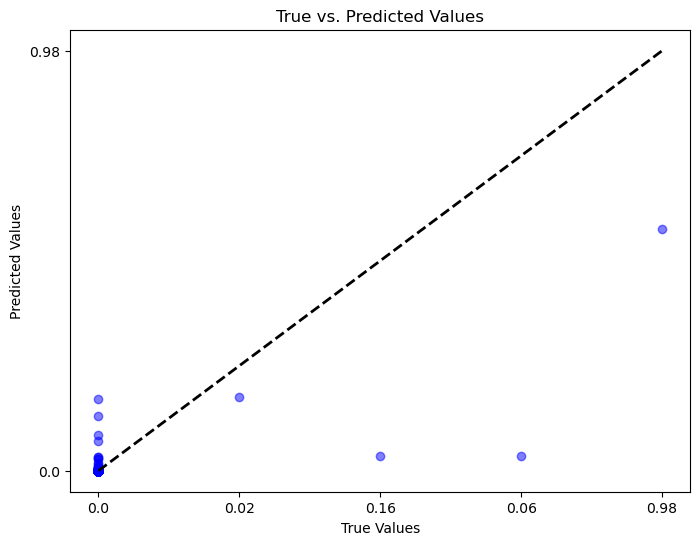

In [32]:
# Scatter Plot of True vs. Predicted Values
plt.figure(figsize=(8, 6))
y_true = y_test
plt.scatter(y_true, y_pred, color='blue', alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.show()

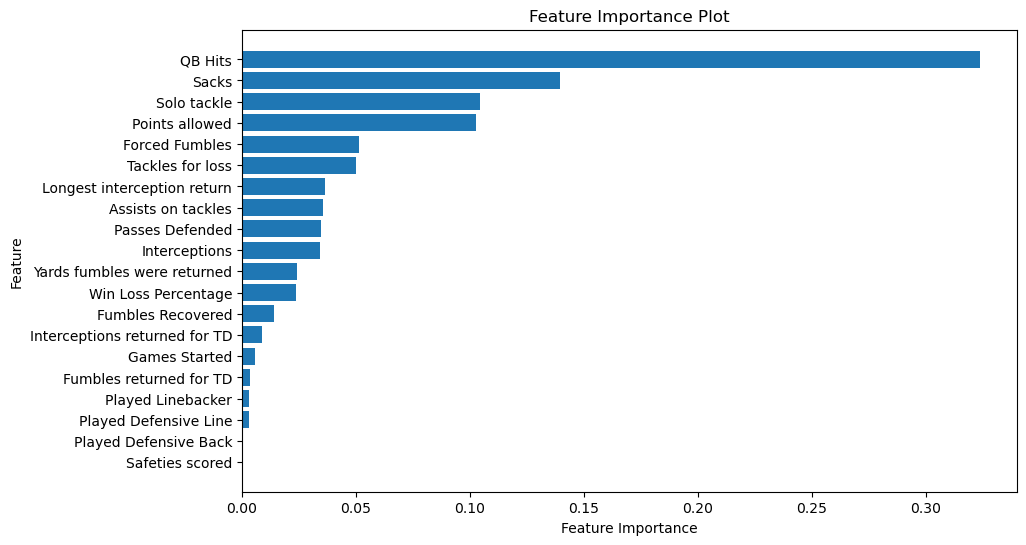

In [33]:
# Get feature importances from the model
feature_importances = rf_regressor.feature_importances_

# Sort the features by their importances
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_importances, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

### For a given year, provide dataframe of top ten players with the highest predicted DPOY Vote % <a class="anchor" id="Step21"></a>

In [34]:
def get_top_predicted_mvp(df_players, model, features, top_n=10):
    """
    Get the top N players with the highest predicted percentage of 1st place votes using the model.
    
    Parameters:
    - df_players: DataFrame containing player information.
    - model: Trained random forest regressor model.
    - features: List of features used for prediction.
    - top_n: Number of top players to return (default is 10).
    
    Returns:
    - df_top_predicted_mvp: DataFrame containing the top N players with their predicted percentage of 1st place votes.
    """
    # Predict the percentage of 1st place votes for all players
    predicted_votes = model.predict(df_players[features])
    
    # Add the predicted votes to the DataFrame
    df_players.loc[:,'Predicted Votes'] = predicted_votes
    
    # Sort DataFrame by predicted votes in descending order and select top N players
    df_top_predicted_mvp = df_players.sort_values(by='Predicted Votes', ascending=False).head(top_n)
    
    return df_top_predicted_mvp

# Define year
year = 2017

# Filter on year
df_players = final_merged_df.loc[final_merged_df['Year']==year]

# Get the top 10 players with the highest predicted percentage of 1st place votes
df_top_predicted_mvp = get_top_predicted_mvp(df_players, rf_regressor, features, top_n=10)

df_top_predicted_mvp = df_top_predicted_mvp[['Player','Won DPOY','Received DPOY Votes','Predicted Votes','% of available votes']]
df_top_predicted_mvp.loc[df_top_predicted_mvp['Received DPOY Votes']==1,'Received DPOY Votes'] = 'X'
df_top_predicted_mvp.loc[df_top_predicted_mvp['Received DPOY Votes']==0,'Received DPOY Votes'] = ''
df_top_predicted_mvp.loc[df_top_predicted_mvp['Won DPOY']==1,'Won DPOY'] = 'X'
df_top_predicted_mvp.loc[df_top_predicted_mvp['Won DPOY']==0,'Won DPOY'] = ''

print("Top 10 players with the highest predicted percentage of 1st place votes:")
df_top_predicted_mvp

Top 10 players with the highest predicted percentage of 1st place votes:


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


,Player,Won DPOY,Received DPOY Votes,Predicted Votes,% of available votes
18801,Aaron Donald,X,X,0.2859,0.46
18693,Calais Campbell,,X,0.2393,0.34
18650,Chandler Jones,,X,0.0952,0.1
18683,Cameron Jordan,,X,0.0482,0.02
18775,DeMarcus Lawrence,,X,0.0228,0.02
18599,Harrison Smith,,X,0.0142,0.02
18711,Xavier Rhodes,,X,0.0138,0.02
18539,Bobby Wagner,,X,0.0120,0.02
18816,Everson Griffen,,,0.0107,0.0
18895,Yannick Ngakoue,,,0.0076,0.0


### Create and populate Predicted Votes column using trained model <a class="anchor" id="Step22"></a>

In [35]:
# Predict the percentage of 1st place votes for all players
predicted_votes = rf_regressor.predict(data[features])

# Add the predicted votes to the DataFrame
data.loc[:,'Predicted Votes'] = predicted_votes

data

,Player,Year,Team,Age,Position,G,Games Started,Interceptions,Yards fumbles were returned,Interceptions returned for TD,...,Safeties scored,Win Loss Percentage,Points allowed,Received DPOY Votes,% of available votes,Won DPOY,Played Defensive Line,Played Linebacker,Played Defensive Back,Predicted Votes
0,Keith Brooking,2003,Atlanta Falcons,28,LILB,16,16,0.0000,0.0000,0.0000,...,0.0000,0.3130,422.0000,0.0000,0.0,0.0000,0,1,0,0.0348
1,Donnie Edwards,2003,San Diego Chargers,30,RLB,16,16,2.0000,27.0000,0.0000,...,0.0000,0.2500,441.0000,0.0000,0.0,0.0000,0,1,0,0.0090
2,Ray Lewis,2003,Baltimore Ravens,28,RILB,16,16,6.0000,99.0000,1.0000,...,0.0000,0.6250,281.0000,1.0000,0.86,1.0000,0,1,0,0.6017
3,David Thornton,2003,Indianapolis Colts,25,RLB,16,16,2.0000,3.0000,0.0000,...,0.0000,0.7500,336.0000,0.0000,0.0,0.0000,0,1,0,0.0000
4,Micheal Barrow,2003,New York Giants,33,MLB,16,16,0.0000,0.0000,0.0000,...,0.0000,0.2500,387.0000,0.0000,0.0,0.0000,0,1,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28395,Benning Potoa'e,2023,Washington Commanders,27,DT,1,0,0.0000,0.0000,0.0000,...,0.0000,0.2350,518.0000,0.0000,0.0,0.0000,1,0,0,0.0000
28419,Brandon Smith,2023,Philadelphia Eagles,22,LB,2,0,0.0000,0.0000,0.0000,...,0.0000,0.6470,428.0000,0.0000,0.0,0.0000,0,1,0,0.0000
28437,Kiondre Thomas,2023,Green Bay Packers,25,CB,1,0,0.0000,0.0000,0.0000,...,0.0000,0.5290,350.0000,0.0000,0.0,0.0000,0,0,1,0.0000
28445,Payton Turner,2023,New Orleans Saints,25,DE,2,0,0.0000,0.0000,0.0000,...,0.0000,0.5290,327.0000,0.0000,0.0,0.0000,1,0,0,0.0000


In [36]:
final_merged_df

,Player,Year,Team,Age,Position,G,Games Started,Interceptions,Yards fumbles were returned,Interceptions returned for TD,...,Safeties scored,Win Loss Percentage,Points allowed,Received DPOY Votes,% of available votes,Won DPOY,Played Defensive Line,Played Linebacker,Played Defensive Back,Predicted Votes
0,Keith Brooking,2003,Atlanta Falcons,28,LILB,16,16,0.0000,0.0000,0.0000,...,0.0000,0.3130,422.0000,0.0000,0.0,0.0000,0,1,0,0.0348
1,Donnie Edwards,2003,San Diego Chargers,30,RLB,16,16,2.0000,27.0000,0.0000,...,0.0000,0.2500,441.0000,0.0000,0.0,0.0000,0,1,0,0.0090
2,Ray Lewis,2003,Baltimore Ravens,28,RILB,16,16,6.0000,99.0000,1.0000,...,0.0000,0.6250,281.0000,1.0000,0.86,1.0000,0,1,0,0.6017
3,David Thornton,2003,Indianapolis Colts,25,RLB,16,16,2.0000,3.0000,0.0000,...,0.0000,0.7500,336.0000,0.0000,0.0,0.0000,0,1,0,0.0000
4,Micheal Barrow,2003,New York Giants,33,MLB,16,16,0.0000,0.0000,0.0000,...,0.0000,0.2500,387.0000,0.0000,0.0,0.0000,0,1,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28395,Benning Potoa'e,2023,Washington Commanders,27,DT,1,0,0.0000,0.0000,0.0000,...,0.0000,0.2350,518.0000,0.0000,0.0,0.0000,1,0,0,0.0000
28419,Brandon Smith,2023,Philadelphia Eagles,22,LB,2,0,0.0000,0.0000,0.0000,...,0.0000,0.6470,428.0000,0.0000,0.0,0.0000,0,1,0,0.0000
28437,Kiondre Thomas,2023,Green Bay Packers,25,CB,1,0,0.0000,0.0000,0.0000,...,0.0000,0.5290,350.0000,0.0000,0.0,0.0000,0,0,1,0.0000
28445,Payton Turner,2023,New Orleans Saints,25,DE,2,0,0.0000,0.0000,0.0000,...,0.0000,0.5290,327.0000,0.0000,0.0,0.0000,1,0,0,0.0000


### Iteratively Normalize Vote % by Year so that the sum of all player predictions = 100%

In [37]:
list_of_years = [year for year in range(2003, 2024)]

for year in list_of_years:
    normalization_factor = 1/data.loc[data['Year']==year]['Predicted Votes'].sum()
    data.loc[data['Year']==year,'Predicted Votes'] = data['Predicted Votes']*normalization_factor
    data.loc[data['Year']==year]['Predicted Votes'].sum()

### Populate difference of actual vote % and normalized predicted vote %

In [38]:
data['Actual Vote % Minus Predicted Vote %'] = data['% of available votes'].astype(float) - data['Predicted Votes']

### Determine how accurately the model correctly predicted the DPOY.  <a class="anchor" id="Step23"></a>

In [39]:
list_of_years = [year for year in range(2003, 2024)]

list_model_predicted_correctly = []
list_model_predicted_incorrectly = []

for year in list_of_years:
    
    # Define dataframe
    specific_year_df = data.loc[data['Year']==year].sort_values('Predicted Votes',ascending=False)
    specific_year_df = specific_year_df.reset_index()
    
    if specific_year_df.loc[0]['Won DPOY']==1:
        list_model_predicted_correctly.append(year)
    
    if specific_year_df.loc[0]['Won DPOY']==0:
        list_model_predicted_incorrectly.append(year)
        
len(list_model_predicted_correctly)/(len(list_model_predicted_correctly)+len(list_model_predicted_incorrectly))

0.7142857142857143

In [40]:
list_model_predicted_incorrectly

[2010, 2013, 2016, 2019, 2020, 2023]

In [54]:
year = 2010
DPOY_2010 = data.loc[(data['Year']==year)&(data['Received DPOY Votes'])==1].sort_values('Predicted Votes',ascending=False)
DPOY_2010.to_excel('2010 DPOY.xlsx')

In [55]:
year = 2016
DPOY_2016 = data.loc[(data['Year']==year)&(data['Received DPOY Votes'])==1].sort_values('Predicted Votes',ascending=False)
DPOY_2016.to_excel('2016 DPOY.xlsx')

In [58]:
year = 2019
DPOY_2019 = data.loc[(data['Year']==year)&(data['Received DPOY Votes'])==1].sort_values('Predicted Votes',ascending=False)
#DPOY_2019.to_excel('2019 DPOY.xlsx')
DPOY_2019

,Player,Year,Team,Age,Position,G,Games Started,Interceptions,Yards fumbles were returned,Interceptions returned for TD,...,Win Loss Percentage,Points allowed,Received DPOY Votes,% of available votes,Won DPOY,Played Defensive Line,Played Linebacker,Played Defensive Back,Predicted Votes,Actual Vote % Minus Predicted Vote %
21372,Chandler Jones,2019,Arizona Cardinals,29,LOLB,16,16,0.0000,0.0000,0.0000,...,0.3440,442.0000,1.0000,0.28,0.0000,0,1,0,0.3428,-0.0628
21441,T.J. Watt,2019,Pittsburgh Steelers,25,LOLB,16,16,2.0000,7.0000,0.0000,...,0.5000,303.0000,1.0000,0.2,0.0000,0,1,0,0.3234,-0.1234
21347,Shaquil Barrett,2019,Tampa Bay Buccaneers,27,ROLB,16,16,1.0000,4.0000,0.0000,...,0.4380,449.0000,1.0000,0.04,0.0000,0,1,0,0.1155,-0.0755
21297,Danielle Hunter,2019,Minnesota Vikings,25,LDE,16,16,0.0000,0.0000,0.0000,...,0.6250,303.0000,1.0000,0.02,0.0000,1,0,0,0.0364,-0.0164
21334,Tre'Davious White,2019,Buffalo Bills,24,RCB/LCB,15,15,6.0000,57.0000,0.0000,...,0.6250,259.0000,1.0000,0.02,0.0000,0,0,1,0.0215,-0.0015
21499,Aaron Donald,2019,Los Angeles Rams,28,RDE,16,16,0.0000,0.0000,0.0000,...,0.5630,364.0000,1.0000,0.02,0.0000,1,0,0,0.0208,-0.0008
21357,Stephon Gilmore,2019,New England Patriots,29,RCB,16,16,6.0000,126.0000,2.0000,...,0.7500,225.0000,1.0000,0.42,1.0000,0,0,1,0.0170,0.4030


In [57]:
year = 2020
DPOY_2020 = data.loc[(data['Year']==year)&(data['Received DPOY Votes'])==1].sort_values('Predicted Votes',ascending=False)
DPOY_2020.to_excel('2020 DPOY.xlsx')

In [44]:
year = 2023
DPOY_2023 = data.loc[(data['Year']==year)&(data['Received DPOY Votes'])==1].sort_values('Predicted Votes',ascending=False)
#DPOY_2023.to_excel('2023 DPOY.xlsx')
DPOY_2023

,Player,Year,Team,Age,Position,G,Games Started,Interceptions,Yards fumbles were returned,Interceptions returned for TD,...,Win Loss Percentage,Points allowed,Received DPOY Votes,% of available votes,Won DPOY,Played Defensive Line,Played Linebacker,Played Defensive Back,Predicted Votes,Actual Vote % Minus Predicted Vote %
27246,T.J. Watt,2023,Pittsburgh Steelers,29,LB,17,17,1.0000,24.0000,0.0000,...,0.5880,324.0000,1.0000,0.3111111111111111,0.0000,0,1,0,0.2866,0.0245
27356,Myles Garrett,2023,Cleveland Browns,28,DE,16,16,0.0000,0.0000,0.0000,...,0.6470,362.0000,1.0000,0.36666666666666664,1.0000,1,0,0,0.2624,0.1043
27331,Micah Parsons,2023,Dallas Cowboys,24,LB,17,17,0.0000,0.0000,0.0000,...,0.7060,315.0000,1.0000,0.19777777777777777,0.0000,0,1,0,0.1723,0.0255
27207,Maxx Crosby,2023,Las Vegas Raiders,26,DE,17,17,0.0000,0.0000,0.0000,...,0.4710,331.0000,1.0000,0.04666666666666667,0.0000,1,0,0,0.0669,-0.0203
27216,DaRon Bland,2023,Dallas Cowboys,24,CB,17,15,9.0000,209.0000,5.0000,...,0.7060,315.0000,1.0000,0.03111111111111111,0.0000,0,0,1,0.0322,-0.0011
27119,Roquan Smith,2023,Baltimore Ravens,26,LB,16,16,1.0000,30.0000,0.0000,...,0.7650,280.0000,1.0000,0.008888888888888889,0.0000,0,1,0,0.0157,-0.0068
27132,Antoine Winfield Jr.,2023,Tampa Bay Buccaneers,25,S,17,17,3.0000,28.0000,0.0000,...,0.5290,325.0000,1.0000,0.015555555555555555,0.0000,0,0,1,0.0130,0.0026
27122,Fred Warner,2023,San Francisco 49ers,27,LB,17,17,4.0000,66.0000,0.0000,...,0.7060,298.0000,1.0000,0.015555555555555555,0.0000,0,1,0,0.0112,0.0044
27198,Khalil Mack,2023,Los Angeles Chargers,32,OLB,17,17,0.0000,0.0000,0.0000,...,0.2940,398.0000,1.0000,0.0022222222222222222,0.0000,0,1,0,0.0053,-0.0031
27309,Justin Madubuike,2023,Baltimore Ravens,26,DT,17,17,0.0000,0.0000,0.0000,...,0.7650,280.0000,1.0000,0.0022222222222222222,0.0000,1,0,0,0.0028,-0.0006


# Stage 6 -  Think of and answer trivia questions using both the underlying data and the regression model predictions

### Determining which players had higher Actual Vote Share % than predicted <a class="anchor" id="Step24"></a>

In [45]:
data.sort_values('Predicted Votes',ascending=False)

# Determining which players had higher actual win % than expected
data.loc[final_merged_df['Won DPOY']==1].sort_values('Actual Vote % Minus Predicted Vote %', ascending=False)

,Player,Year,Team,Age,Position,G,Games Started,Interceptions,Yards fumbles were returned,Interceptions returned for TD,...,Win Loss Percentage,Points allowed,Received DPOY Votes,% of available votes,Won DPOY,Played Defensive Line,Played Linebacker,Played Defensive Back,Predicted Votes,Actual Vote % Minus Predicted Vote %
21357,Stephon Gilmore,2019,New England Patriots,29,RCB,16,16,6.0000,126.0000,2.0000,...,0.7500,225.0000,1.0000,0.42,1.0000,0,0,1,0.0170,0.4030
12025,J.J. Watt,2012,Houston Texans,23,LDE,16,16,0.0000,0.0000,0.0000,...,0.7500,331.0000,1.0000,0.98,1.0000,1,0,0,0.5970,0.3830
2,Ray Lewis,2003,Baltimore Ravens,28,RILB,16,16,6.0000,99.0000,1.0000,...,0.6250,281.0000,1.0000,0.86,1.0000,0,1,0,0.5478,0.3122
24023,T.J. Watt,2021,Pittsburgh Steelers,27,LOLB,15,15,0.0000,0.0000,0.0000,...,0.5590,398.0000,1.0000,0.84,1.0000,0,1,0,0.5558,0.2842
20029,Aaron Donald,2018,Los Angeles Rams,27,RDT,16,16,0.0000,0.0000,0.0000,...,0.8130,384.0000,1.0000,0.9,1.0000,1,0,0,0.6412,0.2588
13268,Luke Kuechly,2013,Carolina Panthers,22,MLB,16,16,4.0000,33.0000,0.0000,...,0.7500,241.0000,1.0000,0.38,1.0000,0,1,0,0.1661,0.2139
2654,Brian Urlacher,2005,Chicago Bears,27,MLB,16,16,0.0000,0.0000,0.0000,...,0.6880,202.0000,1.0000,0.68,1.0000,0,1,0,0.4697,0.2103
14645,J.J. Watt,2014,Houston Texans,25,LDE,16,16,1.0000,80.0000,1.0000,...,0.5630,307.0000,1.0000,1.0,1.0000,1,0,0,0.8099,0.1901
5322,Bob Sanders,2007,Indianapolis Colts,26,SS,15,15,2.0000,32.0000,0.0000,...,0.8130,262.0000,1.0000,0.62,1.0000,0,0,1,0.4300,0.1900
7997,Charles Woodson,2009,Green Bay Packers,33,LCB,16,16,9.0000,179.0000,3.0000,...,0.6880,297.0000,1.0000,0.56,1.0000,0,0,1,0.3896,0.1704


### Determining which players had the highest predicted DPOY vote share % BUT DIDNT WIN <a class="anchor" id="Step25"></a>

In [46]:
# Determining which players had the highest expected vote % BUT DIDNT WIN
data.loc[data['Won DPOY']!=1].sort_values('Predicted Votes', ascending=False)

,Player,Year,Team,Age,Position,G,Games Started,Interceptions,Yards fumbles were returned,Interceptions returned for TD,...,Win Loss Percentage,Points allowed,Received DPOY Votes,% of available votes,Won DPOY,Played Defensive Line,Played Linebacker,Played Defensive Back,Predicted Votes,Actual Vote % Minus Predicted Vote %
22695,T.J. Watt,2020,Pittsburgh Steelers,26,LOLB,15,15,1.0000,0.0000,0.0000,...,0.7500,312.0000,1.0000,0.4,0.0000,0,1,0,0.4075,-0.0075
21372,Chandler Jones,2019,Arizona Cardinals,29,LOLB,16,16,0.0000,0.0000,0.0000,...,0.3440,442.0000,1.0000,0.28,0.0000,0,1,0,0.3428,-0.0628
17271,Von Miller,2016,Denver Broncos,27,LOLB,16,16,0.0000,0.0000,0.0000,...,0.5630,297.0000,1.0000,0.34,0.0000,0,1,0,0.3285,0.0115
21441,T.J. Watt,2019,Pittsburgh Steelers,25,LOLB,16,16,2.0000,7.0000,0.0000,...,0.5000,303.0000,1.0000,0.2,0.0000,0,1,0,0.3234,-0.1234
18693,Calais Campbell,2017,Jacksonville Jaguars,31,RDE,16,16,0.0000,0.0000,0.0000,...,0.6250,268.0000,1.0000,0.34,0.0000,1,0,0,0.3033,0.0367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9757,Earl Mitchell,2010,Houston Texans,23,DT,15,0,0.0000,0.0000,0.0000,...,0.3750,427.0000,0.0000,0.0,0.0000,1,0,0,0.0000,0.0000
9758,Arthur Moats,2010,Buffalo Bills,22,LB,15,4,0.0000,0.0000,0.0000,...,0.2500,425.0000,0.0000,0.0,0.0000,0,1,0,0.0000,0.0000
9759,Raymond Ventrone,2010,Cleveland Browns,28,DB,16,0,0.0000,0.0000,0.0000,...,0.3130,332.0000,0.0000,0.0,0.0000,0,0,1,0.0000,0.0000
9760,Kyle Wilson,2010,New York Jets,23,DB,16,6,0.0000,0.0000,0.0000,...,0.6880,304.0000,0.0000,0.0,0.0000,0,0,1,0.0000,0.0000


### Determining which player has the highest predicted DPOY vote share% BUT DIDNT RECEIVE A DPOY VOTE <a class="anchor" id="Step26"></a>

In [47]:
# Determining which players had the highest expected vote % and didn't win
data.loc[data['Received DPOY Votes']!=1].sort_values('Actual Vote % Minus Predicted Vote %', ascending=True)

,Player,Year,Team,Age,Position,G,Games Started,Interceptions,Yards fumbles were returned,Interceptions returned for TD,...,Win Loss Percentage,Points allowed,Received DPOY Votes,% of available votes,Won DPOY,Played Defensive Line,Played Linebacker,Played Defensive Back,Predicted Votes,Actual Vote % Minus Predicted Vote %
24147,Myles Garrett,2021,Cleveland Browns,26,LDE,17,17,0.0000,0.0000,0.0000,...,0.4710,371.0000,0.0000,0.0,0.0000,1,0,0,0.1556,-0.1556
22898,Trey Hendrickson,2020,New Orleans Saints,26,RDE,15,15,0.0000,0.0000,0.0000,...,0.7500,337.0000,0.0000,0.0,0.0000,1,0,0,0.1247,-0.1247
13260,NaVorro Bowman,2013,San Francisco 49ers,25,LILB,16,16,2.0000,93.0000,1.0000,...,0.7500,272.0000,0.0000,0.0,0.0000,0,1,0,0.1209,-0.1209
8415,Dwight Freeney,2009,Indianapolis Colts,29,RDE,14,9,0.0000,0.0000,0.0000,...,0.8750,307.0000,0.0000,0.0,0.0000,1,0,0,0.1079,-0.1079
24304,Trey Hendrickson,2021,Cincinnati Bengals,27,RDE,16,14,0.0000,0.0000,0.0000,...,0.5880,376.0000,0.0000,0.0,0.0000,1,0,0,0.1022,-0.1022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9733,Cornelius Brown,2010,Indianapolis Colts,22,DB,10,0,0.0000,0.0000,0.0000,...,0.6250,388.0000,0.0000,0.0,0.0000,0,0,1,0.0000,0.0000
9732,Jonathan Babineaux,2010,Atlanta Falcons,29,LDT,15,15,1.0000,0.0000,0.0000,...,0.8130,288.0000,0.0000,0.0,0.0000,1,0,0,0.0000,0.0000
9731,Major Wright,2010,Chicago Bears,22,DB,11,0,0.0000,0.0000,0.0000,...,0.6880,286.0000,0.0000,0.0,0.0000,0,0,1,0.0000,0.0000
9737,Jeff Charleston,2010,New Orleans Saints,27,DE,16,1,0.0000,0.0000,0.0000,...,0.6880,307.0000,0.0000,0.0,0.0000,1,0,0,0.0000,0.0000


### Determine which player had the largest negative descrepancy between Actual Vote % and Predicted Vote % <a class="anchor" id="Step27"></a>

In [48]:
# Determining which *vote-receiving players* had the highest expected vote % and didn't win
data.loc[(data['Won DPOY']!=1)&(data['Received DPOY Votes']==1)].sort_values('Actual Vote % Minus Predicted Vote %', ascending=True)

,Player,Year,Team,Age,Position,G,Games Started,Interceptions,Yards fumbles were returned,Interceptions returned for TD,...,Win Loss Percentage,Points allowed,Received DPOY Votes,% of available votes,Won DPOY,Played Defensive Line,Played Linebacker,Played Defensive Back,Predicted Votes,Actual Vote % Minus Predicted Vote %
12073,Von Miller,2012,Denver Broncos,23,LILB,16,16,1.0000,26.0000,1.0000,...,0.8130,289.0000,1.0000,0.02,0.0000,0,1,0,0.1811,-0.1611
13317,J.J. Watt,2013,Houston Texans,24,LDE,16,16,0.0000,0.0000,0.0000,...,0.1250,428.0000,1.0000,0.04,0.0000,1,0,0,0.1890,-0.1490
21441,T.J. Watt,2019,Pittsburgh Steelers,25,LOLB,16,16,2.0000,7.0000,0.0000,...,0.5000,303.0000,1.0000,0.2,0.0000,0,1,0,0.3234,-0.1234
21347,Shaquil Barrett,2019,Tampa Bay Buccaneers,27,ROLB,16,16,1.0000,4.0000,0.0000,...,0.4380,449.0000,1.0000,0.04,0.0000,0,1,0,0.1155,-0.0755
21372,Chandler Jones,2019,Arizona Cardinals,29,LOLB,16,16,0.0000,0.0000,0.0000,...,0.3440,442.0000,1.0000,0.28,0.0000,0,1,0,0.3428,-0.0628
18683,Cameron Jordan,2017,New Orleans Saints,28,LDE,16,16,1.0000,0.0000,1.0000,...,0.6880,326.0000,1.0000,0.02,0.0000,1,0,0,0.0611,-0.0411
10648,NaVorro Bowman,2011,San Francisco 49ers,23,LILB,16,16,0.0000,0.0000,0.0000,...,0.8130,229.0000,1.0000,0.02,0.0000,0,1,0,0.0579,-0.0379
25594,Maxx Crosby,2022,Las Vegas Raiders,25,DE,17,17,0.0000,0.0000,0.0000,...,0.3530,418.0000,1.0000,0.017777777777777778,0.0000,1,0,0,0.0440,-0.0262
10708,Jason Pierre-Paul,2011,New York Giants,22,RDE,16,12,0.0000,0.0000,0.0000,...,0.5630,400.0000,1.0000,0.1,0.0000,1,0,0,0.1260,-0.0260
2885,Nathan Vasher,2005,Chicago Bears,24,RCB,16,15,8.0000,145.0000,1.0000,...,0.6880,202.0000,1.0000,0.02,0.0000,0,0,1,0.0436,-0.0236


### Determine which players have the most interceptions since 2003 <a class="anchor" id="Step28"></a>

In [77]:
interceptions_df = data.sort_values('Interceptions',ascending=False)
#interceptions_df.to_excel('Interceptions record.xlsx')
interceptions_df

,Player,Year,Team,Age,Position,G,Games Started,Interceptions,Yards fumbles were returned,Interceptions returned for TD,...,Win Loss Percentage,Points allowed,Received DPOY Votes,% of available votes,Won DPOY,Played Defensive Line,Played Linebacker,Played Defensive Back,Predicted Votes,Actual Vote % Minus Predicted Vote %
24053,Trevon Diggs,2021,Dallas Cowboys,23,LCB,16,16,11.0000,142.0000,2.0000,...,0.7060,358.0000,0.0000,0.0,0.0000,0,0,1,0.0121,-0.0121
4074,Asante Samuel,2006,New England Patriots,25,LCB/RCB,15,15,10.0000,120.0000,0.0000,...,0.7500,237.0000,0.0000,0.0,0.0000,0,0,1,0.0570,-0.0570
5519,Antonio Cromartie,2007,San Diego Chargers,23,RCB,16,8,10.0000,144.0000,1.0000,...,0.6880,284.0000,1.0000,0.06,0.0000,0,0,1,0.0370,0.0230
2761,Deltha O'Neal,2005,Cincinnati Bengals,28,LCB,15,14,10.0000,103.0000,0.0000,...,0.6880,350.0000,0.0000,0.0,0.0000,0,0,1,0.0068,-0.0068
4011,Champ Bailey,2006,Denver Broncos,28,LCB,16,16,10.0000,162.0000,1.0000,...,0.5630,305.0000,1.0000,0.32,0.0000,0,0,1,0.1875,0.1325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11160,Andre Neblett,2011,Carolina Panthers,23,DT,12,4,0.0000,0.0000,0.0000,...,0.3750,429.0000,0.0000,0.0,0.0000,1,0,0,0.0000,0.0000
11161,Frank Okam,2011,Tampa Bay Buccaneers,26,DT,9,3,0.0000,0.0000,0.0000,...,0.2500,494.0000,0.0000,0.0,0.0000,1,0,0,0.0000,0.0000
11163,Jason Trusnik,2011,Miami Dolphins,27,DE,16,0,0.0000,0.0000,0.0000,...,0.3750,313.0000,0.0000,0.0,0.0000,1,0,0,0.0000,0.0000
11164,Isa Abdul-Quddus,2011,New Orleans Saints,22,DB,16,1,0.0000,0.0000,0.0000,...,0.8130,339.0000,0.0000,0.0,0.0000,0,0,1,0.0000,0.0000


### Determine which players have the most sacks since 2003 <a class="anchor" id="Step29"></a>

In [ ]:
data_refined = data[['Player','Year','Sacks']]
data_refined = data_refined.sort_values('Sacks',ascending=False)
data_refined.to_excel('Sack Record.xlsx')

### Determine best and worst defenses since 2003 <a class="anchor" id="Step30"></a>

In [78]:
data.sort_values('Points allowed',ascending=True)
print(201/16)
print(519/16)
data.sort_values('Points allowed',ascending=True)

12.5625
32.4375


,Player,Year,Team,Age,Position,G,Games Started,Interceptions,Yards fumbles were returned,Interceptions returned for TD,...,Win Loss Percentage,Points allowed,Received DPOY Votes,% of available votes,Won DPOY,Played Defensive Line,Played Linebacker,Played Defensive Back,Predicted Votes,Actual Vote % Minus Predicted Vote %
4184,Chris McAlister,2006,Baltimore Ravens,29,LCB,16,16,6.0000,121.0000,2.0000,...,0.8130,201.0000,0.0000,0.0,0.0000,0,0,1,0.0083,-0.0083
4148,Dawan Landry,2006,Baltimore Ravens,24,SS,16,14,5.0000,101.0000,1.0000,...,0.8130,201.0000,0.0000,0.0,0.0000,0,0,1,0.0013,-0.0013
5057,Jamaine Winborne,2006,Baltimore Ravens,26,DB,1,0,0.0000,0.0000,0.0000,...,0.8130,201.0000,0.0000,0.0,0.0000,0,0,1,0.0000,0.0000
5097,Dan Cody,2006,Baltimore Ravens,25,LB,2,0,0.0000,0.0000,0.0000,...,0.8130,201.0000,0.0000,0.0,0.0000,0,1,0,0.0000,0.0000
4118,Ed Reed,2006,Baltimore Ravens,28,FS,16,16,5.0000,70.0000,1.0000,...,0.8130,201.0000,0.0000,0.0,0.0000,0,0,1,0.0025,-0.0025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23350,Frank Herron,2020,Detroit Lions,26,DT,4,0,0.0000,0.0000,0.0000,...,0.3130,519.0000,0.0000,0.0,0.0000,1,0,0,0.0000,0.0000
22782,Christian Jones,2020,Detroit Lions,29,LLB,16,13,0.0000,0.0000,0.0000,...,0.3130,519.0000,0.0000,0.0,0.0000,0,1,0,0.0000,0.0000
22807,Reggie Ragland,2020,Detroit Lions,27,MLB,16,6,0.0000,0.0000,0.0000,...,0.3130,519.0000,0.0000,0.0,0.0000,0,1,0,0.0000,0.0000
23381,Jason Cabinda,2020,Detroit Lions,24,LB,16,2,0.0000,0.0000,0.0000,...,0.3130,519.0000,0.0000,0.0,0.0000,0,1,0,0.0000,0.0000


In [79]:
32.44/12.56

2.5828025477707004

### Determine what % of DPOY are in each position group <a class="anchor" id="Step31"></a>

In [ ]:
dpoy_winners = data.loc[data['Won DPOY']==1]

dpoy_DL_winners = dpoy_winners.loc[dpoy_winners['Played Defensive Line']==1]

dpoy_LB_winners = dpoy_winners.loc[dpoy_winners['Played Linebacker']==1]

dpoy_DB_winners = dpoy_winners.loc[dpoy_winners['Played Defensive Back']==1]

print(len(dpoy_DL_winners)/len(dpoy_winners))
print(len(dpoy_LB_winners)/len(dpoy_winners))
print(len(dpoy_DB_winners)/len(dpoy_winners))

### Determine what % of DPOY Nods go to each position group  <a class="anchor" id="Step32"></a>

In [80]:
dpoy_votes_received = data.loc[data['Received DPOY Votes']==1]

dpoy_votes_received

dpoy_DL_nods = dpoy_votes_received.loc[dpoy_votes_received['Played Defensive Line']==1]

dpoy_LB_nods = dpoy_votes_received.loc[dpoy_votes_received['Played Linebacker']==1]

dpoy_DB_nods = dpoy_votes_received.loc[dpoy_votes_received['Played Defensive Back']==1]

print(len(dpoy_DL_nods)/len(dpoy_votes_received))
print(len(dpoy_LB_nods)/len(dpoy_votes_received))
print(len(dpoy_DB_nods)/len(dpoy_votes_received))

0.376
0.36
0.264


# Stage 7 - Test out how well the model can predict the 5 DPOY for 5 years of test data that it was not trained on. 

### Run 50 trials using 5 random years to test <a class="anchor" id="Step33"></a>

In [82]:
trials = 0

prediction_accuracy_list = []

while trials < 51:
    
    print(trials)
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error

    # Assuming 'X' is your feature matrix and 'y' is your target variable (percentage of 1st place votes)
    # Split the data into training and testing sets

    # Filter the data to exclude
    data = final_merged_df

    # Assuming 'features' is a list of features you want to use for prediction
    features = ['Games Started',
                 'Interceptions',
                 'Yards fumbles were returned',
                 'Interceptions returned for TD',
                 'Longest interception return',
                 'Passes Defended',
                 'Forced Fumbles',
                 'Fumbles Recovered',
                 'Fumbles returned for TD',
                 'Sacks',
                 'Solo tackle',
                 'Assists on tackles',
                 'Tackles for loss',
                 'QB Hits',
                 'Safeties scored',
                'Win Loss Percentage',
                'Points allowed',
                'Played Defensive Line',
                'Played Linebacker',
                'Played Defensive Back']  # Add your features here

    target = '% of available votes'


    # Generate a list of years between 2003 and 2023
    all_years = list(range(2003, 2024))

    # Randomly select 5 years for testing
    testing_years = random.sample(all_years, 5)

    # Create a list of the remaining 16 years for training
    training_years = [year for year in all_years if year not in testing_years]

    training_data = data.loc[data['Year'].isin(training_years)]
    testing_data = data.loc[data['Year'].isin(testing_years)]

    X_train,X_test = training_data[features], testing_data[features]

    y_train, y_test = training_data[target], testing_data[target]

    # Initialize the random forest regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the regressor
    rf_regressor.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = rf_regressor.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    list_model_predicted_correctly = []
    list_model_predicted_incorrectly = []

    for year in testing_years:
    
        # Define dataframe
        df_players = final_merged_df.loc[final_merged_df['Year']==year]

        # Get the top 10 players with the highest predicted percentage of 1st place votes
        df_top_predicted_mvp = get_top_predicted_mvp(df_players, rf_regressor, features, top_n=10)

        df_top_predicted_mvp = df_top_predicted_mvp[['Player','Won DPOY','Received DPOY Votes','Predicted Votes','% of available votes']]
        df_top_predicted_mvp.loc[df_top_predicted_mvp['Received DPOY Votes']==1,'Received DPOY Votes'] = 'X'
        df_top_predicted_mvp.loc[df_top_predicted_mvp['Received DPOY Votes']==0,'Received DPOY Votes'] = ''
        df_top_predicted_mvp.loc[df_top_predicted_mvp['Won DPOY']==1,'Won DPOY'] = 'X'
        df_top_predicted_mvp.loc[df_top_predicted_mvp['Won DPOY']==0,'Won DPOY'] = ''

        df_top_predicted_mvp = df_top_predicted_mvp.reset_index(drop=True)

        if df_top_predicted_mvp.loc[0]['Won DPOY']=='X':
            list_model_predicted_correctly.append(year)

        if df_top_predicted_mvp.loc[0]['Won DPOY']!='X':
            list_model_predicted_incorrectly.append(year)

    prediction_accuracy_value = len(list_model_predicted_correctly)/(len(list_model_predicted_correctly)+len(list_model_predicted_incorrectly))
    prediction_accuracy_list.append(prediction_accuracy_value)
    
    trials = trials + 1


0
Mean Squared Error: 0.00036078171990448787
1


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0002580636411424764
2


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00030942093658621004
3


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00018006790008777575
4


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.000322616811912936
5


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.000335938485153368
6


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0002613257300342027
7


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00028051005897352846
8


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0002550801445361552
9


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0003132847312957738
10


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00018842164764510145
11


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0004018076488277044
12


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.000495750576865541
13


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.000528499172563443
14


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.000326695853825969
15


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0003896900754604341
16


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0003207594231568541
17


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00032999572054415497
18


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00035861874832788
19


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0004281231058135048
20


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00043923890769857234
21


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00032330689717156185
22


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00045239145476073055
23


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0005082017953097431
24


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0003092680078060671
25


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00019879756522007394
26


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00021030888267155364
27


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0005324004494903027
28


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.000492514621277205
29


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00042396204668123023
30


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.000401672003921081
31


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00047887738826431653
32


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00023307287867667972
33


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00033837682252138817
34


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00033673525883695844
35


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0004603562949053202
36


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0005100069093171568
37


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00032142211116800376
38


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00034037504281145937
39


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00040887515781597665
40


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00042830863744296833
41


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0003771333203632752
42


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00035609122684470914
43


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00031961265231912557
44


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0004400338909563298
45


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00040017992685878234
46


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.00028030899391749974
47


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0003846226796551744
48


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0005266581437640293
49


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.000247525630897017
50


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

Mean Squared Error: 0.0002903759399300883


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes
C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

### Evaluate average outcome of the 50 trials <a class="anchor" id="Step34"></a>

In [84]:
sum(prediction_accuracy_list)/len(prediction_accuracy_list)

0.41960784313725485

# Test out how well the model can predict a DPOY for a given year using only the 10 years of data prior to the year

### Cycle through 2013-2023 and test out how well the model can predict a DPOY for a given year using only the 10 years of data prior to each year <a class="anchor" id="Step35"></a>

In [86]:
# Define lists
list_model_predicted_correctly = []
list_model_predicted_incorrectly = []

for year in list(range(2013,2024)):
    
    print(year)
    
    # Define prior 10 years
    prior_10_years = list(range(year-10,year))
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error

    # Assuming 'X' is your feature matrix and 'y' is your target variable (percentage of 1st place votes)
    # Split the data into training and testing sets

    # Filter the data to exclude
    data = final_merged_df

    # Assuming 'features' is a list of features you want to use for prediction
    features = ['Games Started',
                 'Interceptions',
                 'Yards fumbles were returned',
                 'Interceptions returned for TD',
                 'Longest interception return',
                 'Passes Defended',
                 'Forced Fumbles',
                 'Fumbles Recovered',
                 'Fumbles returned for TD',
                 'Sacks',
                 'Solo tackle',
                 'Assists on tackles',
                 'Tackles for loss',
                 'QB Hits',
                 'Safeties scored',
                'Win Loss Percentage',
                'Points allowed',
                'Played Defensive Line',
                'Played Linebacker',
                'Played Defensive Back']  # Add your features here

    target = '% of available votes'

    # Single year for testing
    testing_years = [year]

    # Create a list of the prior 10 years to testing data for training data
    training_years = prior_10_years

    training_data = data.loc[data['Year'].isin(training_years)]
    testing_data = data.loc[data['Year'].isin(testing_years)]

    X_train,X_test = training_data[features], testing_data[features]

    y_train, y_test = training_data[target], testing_data[target]

    # Initialize the random forest regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the regressor
    rf_regressor.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = rf_regressor.predict(X_test)

    # Define dataframe
    df_players = final_merged_df.loc[final_merged_df['Year']==year]

    # Get the top 10 players with the highest predicted percentage of 1st place votes
    df_top_predicted_mvp = get_top_predicted_mvp(df_players, rf_regressor, features, top_n=10)

    df_top_predicted_mvp = df_top_predicted_mvp[['Player','Won DPOY','Received DPOY Votes','Predicted Votes','% of available votes']]
    df_top_predicted_mvp.loc[df_top_predicted_mvp['Received DPOY Votes']==1,'Received DPOY Votes'] = 'X'
    df_top_predicted_mvp.loc[df_top_predicted_mvp['Received DPOY Votes']==0,'Received DPOY Votes'] = ''
    df_top_predicted_mvp.loc[df_top_predicted_mvp['Won DPOY']==1,'Won DPOY'] = 'X'
    df_top_predicted_mvp.loc[df_top_predicted_mvp['Won DPOY']==0,'Won DPOY'] = ''

    df_top_predicted_mvp = df_top_predicted_mvp.reset_index(drop=True)

    if df_top_predicted_mvp.loc[0]['Won DPOY']=='X':
        list_model_predicted_correctly.append(year)

    if df_top_predicted_mvp.loc[0]['Won DPOY']!='X':
        list_model_predicted_incorrectly.append(year)
    

2013


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


2014


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


2015


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


2016


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


2017


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


2018


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


2019


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


2020


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


2021


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


2022


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


2023


C:\Users\Carey\AppData\Local\Temp\ipykernel_17240\2494537906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players.loc[:,'Predicted Votes'] = predicted_votes


### Evaluate how well the model performs only using 10 years of prior history <a class="anchor" id="Step36"></a>

In [87]:
list_model_predicted_correctly

[2014, 2015, 2021, 2022]

In [88]:
list_model_predicted_incorrectly

[2013, 2016, 2017, 2018, 2019, 2020, 2023]

In [89]:
4/11

0.36363636363636365